In [5]:
import torch, os, datetime, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import pandas as pd
import time
from sklearn.metrics import precision_score, recall_score, f1_score

In [6]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Carregando e seperando dataset

In [7]:
batch_size = 32

# Transformações para normalizar o dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carregando o dataset MNIST
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader para o dataset de treinamento e teste
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = list(map(str, range(0, 10)))

##### Visualizando dados

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


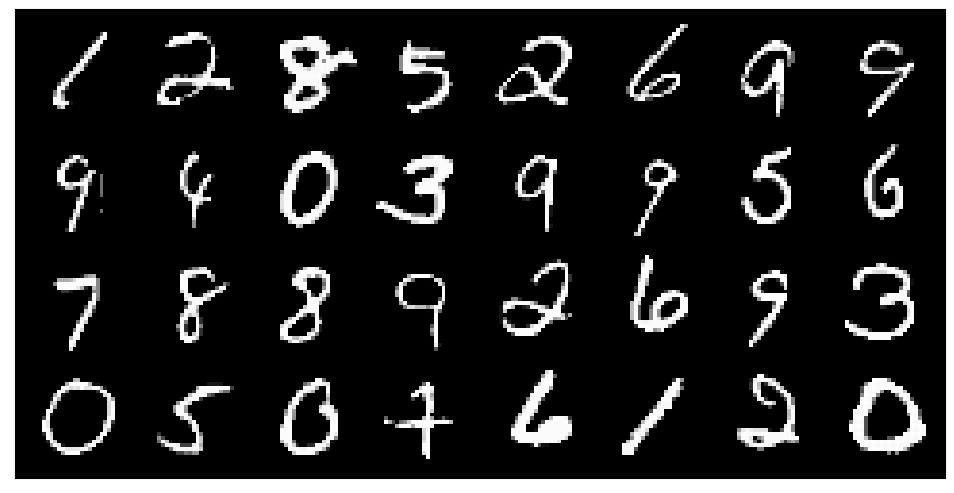

In [9]:
show_batch(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


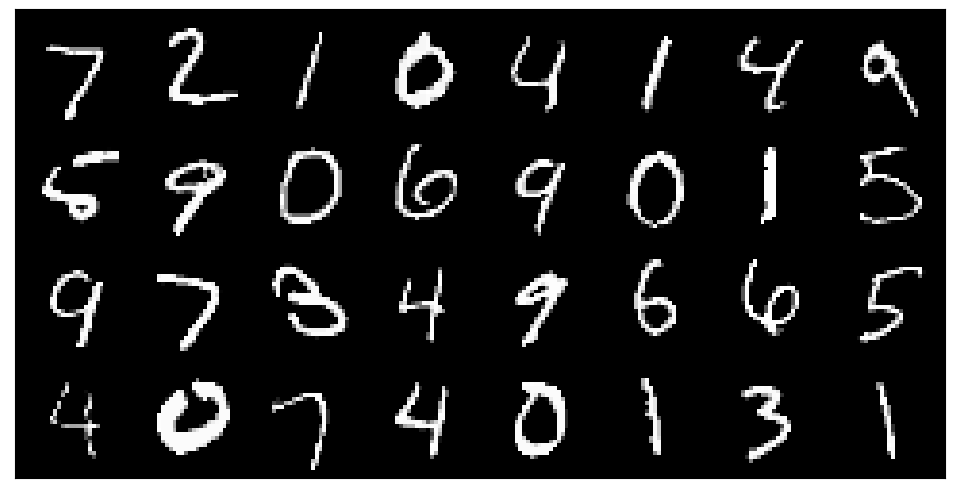

In [10]:
show_batch(testloader)

## Criando uma instância da classe nn.Module para criar redes

#### Explicando cada parâmetro da camada convolucional:

- **in_channels**: Quantos canais de cores os inputs possuem. No caso de imagens em preto e branco, como estamos trabalhando com MNIST, há apenas um canal de cor.

- **out_channels**: Número de filtros (kernels) que serão aplicados à imagem durante a convolução. Cada filtro é responsável por extrair características latentes da imagem.

- **kernel_size**: Dimensão do filtro utilizado na convolução. O valor comum de 3 é amplamente usado, pois é suficiente para capturar detalhes locais, ao mesmo tempo em que percebe padrões maiores na imagem.

- **stride**: Indica de quanto em quantos pixels o filtro será aplicado na imagem.

- **padding**: Adiciona pixels em volta da imagem de entrada durante a convolução para garantir que o tamanho da saída após a convolução permaneça o mesmo que o da entrada.
  - *Observação*: Ao adicionar padding, é preciso ter cuidado com os valores para garantir que a resolução e o tamanho da imagem não sejam afetados de forma indesejada.

- **dropout_prob**: Probabilidade de que um neurônio seja desligado durante o treinamento da rede. Isso é uma técnica de regularização que ajuda a prevenir o overfitting, forçando a rede a aprender representações mais robustas e generalizáveis.

#### Fórmulas das Dimensões de Saída

A fórmula para calcular a dimensão de saída \( W_out \) da convolução é:

$$
W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

E a fórmula para calcular a dimensão de saída \( H_out \) da convolução é:

$$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

Resumindo as trasnformações:

- Entrada Original: 28x28 pixels, 1 canal.
- Após Convolução: 28x28 pixels, 32 canais.
- Após Pooling: 14x14 pixels, 32 canais.
- Entrada para self.fc1: 32 × 14 × 14

In [11]:
class BaseCNN(nn.Module):
    def __init__(self, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, dropout_prob=0.5):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 32 * 14 * 14)
        x = self.fc1(x)
        return x

In [12]:
class DeepCNN(nn.Module):
    def __init__(self, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, dropout_prob=0.5):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Definindo funções úteis

#### Função de treinamento do modelo

In [13]:
def train_model(model, criterion, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()  # Propaga os gradientes
            optimizer.step()  # Atualiza os pesos

            running_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
    
    print('Finished Training!')

#### Função de teste do modelo

In [14]:
def test_model(model, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    loss = test_loss / len(testloader)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return accuracy, loss, precision, recall, f1

#### Função de acurácia de cada classe

In [15]:
# Mudar
def accuracy_classes(model_trained):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    all_accuracy = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model_trained(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        all_accuracy.append(accuracy)
    
    return all_accuracy

#### Função para prever classe de uma imagem

In [16]:
def predict_image(image_path, model):
    image = Image.open(image_path).convert('L')  
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    # Adiciona dimensão de batch (1 imagem)
    image = transform(image).unsqueeze(0) 

    # Passando a imagem pela rede
    output = model(image)

    _, predicted_class = torch.max(output, 1)
    print("Classe prevista:", predicted_class.item())


#### Definindo cvs com os parametros e metricas

In [17]:
if (os.path.exists('cnn_models_metrics.csv')):
    model_df = pd.read_csv('cnn_models_metrics.csv')
else:
    model_data = {
        'network': [],
        'conv_kernel_size': [],
        'conv_stride': [],
        'conv_padding': [],
        'pool_kernel_size': [],
        'pool_stride': [],
        'dropout_prob': [],
        'fit_time': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'overall_accuracy ': [],
        'accuracy_0': [],
        'accuracy_1': [],
        'accuracy_2': [],
        'accuracy_3': [],
        'accuracy_4': [],
        'accuracy_5': [],
        'accuracy_6': [],
        'accuracy_7': [],
        'accuracy_8': [],
        'accuracy_9': [],
        'total_epochs': [],
        'learning_rate': [],
    }
    model_df = pd.DataFrame(model_data)

# One Model

#### Instânciando o modelo base, definindo parametros, loss function e otimizador

In [18]:
model = BaseCNN()

learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#### Treinamento o modelo

In [20]:
train_model(model, criterion, optimizer, epochs)

Epoch 1, Loss: 0.12967849092409015
Epoch 2, Loss: 0.12123571763709187
Epoch 3, Loss: 0.11585727842872341
Epoch 4, Loss: 0.11338326055084666
Epoch 5, Loss: 0.10875180969176193
Epoch 6, Loss: 0.10491095401768884
Epoch 7, Loss: 0.09931773659909765
Epoch 8, Loss: 0.09874249405637384
Epoch 9, Loss: 0.09665742406199376
Epoch 10, Loss: 0.09151160414839785
Finished Training!


#### Testando o modleo

In [22]:
accuracy, loss, precision, recall, f1 = test_model(model, criterion)
print(f'Accuracy: {100 * accuracy}%, Test Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Accuracy: 97.89%, Test Loss: 0.0676, Precision: 0.9789, Recall: 0.9789, F1 Score: 0.9789


## Salvando o modelo treinado

In [23]:
if not os.path.exists('modelos_treinados'):
    os.makedirs('modelos_treinados')

current_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
path_model_trained = os.path.join('modelos_treinados', f'model_{current_datetime}.pth')

torch.save(model.state_dict(), path_model_trained)

# N Models

#### Função de criação de derivação da rede base

In [24]:
def create_cnn(conv_kernel_size, conv_stride, conv_padding, pool_kernel_size, pool_stride, dropout_prob):
    class CNNTest(BaseCNN):
        def __init__(self):
            super(CNNTest, self).__init__(conv_kernel_size, conv_stride, conv_padding, pool_kernel_size, pool_stride, dropout_prob)
    return CNNTest()

#### Instanciando os modelos com grid de parametros

In [25]:
grid = [
    {'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.5},
    {'conv_kernel_size': 5, 'conv_stride': 1, 'conv_padding': 2, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.3},
    {'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.7}
]
networks = [create_cnn(**params) for params in grid]

#### Definindo parametros adicionais, loss function e otimizadores

In [26]:
learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) for model in networks]

#### Treinando e testando os modelos

In [30]:
for i, net in enumerate(networks):
    print(f"Treinando Rede Neural {i + 1} com os seguintes parâmetros:")
    print(grid[i])

    start = time.time()
    train_model(net, criterion, optimizers[i], epochs)
    end = time.time()
    total_time = round(end - start, 1)

    accuracy, loss, precision, recall, f1 = test_model(net, criterion)
    print(f'Accuracy: {100 * accuracy}% Test Loss: {loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1 Score: {f1:.4f} Fit Time: {total_time}')
    print('------------------------------------\n')

    class_accuracies = accuracy_classes(net)

    model_data  = {
        'network': [], #colocar como é a rede, podemos criar um nome pra cada rede e por ou algo do genero
        **grid[i],
        'fit_time': total_time,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'overall_accuracy ': accuracy,
        'loss': loss,
        'total_epochs': epochs,
        'learning_rate': learning_rate,
    }

    for idx, acc in enumerate(class_accuracies):
        model_data[f'accuracy_{idx}'] = acc

    # Adicionando o modelo ao dataframe de modelos
    model_df.loc[len(model_df)] = model_data

Treinando Rede Neural 1 com os seguintes parâmetros:
{'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.5}
Epoch 1, Loss: 0.09128022986600796
Epoch 2, Loss: 0.08927064409417411
Epoch 3, Loss: 0.08860103671066463
Epoch 4, Loss: 0.08499003083221614
Epoch 5, Loss: 0.08369098297171294
Epoch 6, Loss: 0.08437506636387358
Epoch 7, Loss: 0.08131213981409868
Epoch 8, Loss: 0.0778803182101498
Epoch 9, Loss: 0.08025946441957106
Epoch 10, Loss: 0.07883438383887212
Finished Training!
Accuracy: 98.03% Test Loss: 0.0655 Precision: 0.9804 Recall: 0.9803 F1 Score: 0.9803 Fit Time: 256.2
------------------------------------

Treinando Rede Neural 2 com os seguintes parâmetros:
{'conv_kernel_size': 5, 'conv_stride': 1, 'conv_padding': 2, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.3}
Epoch 1, Loss: 0.07685931462484101
Epoch 2, Loss: 0.07325596031397581
Epoch 3, Loss: 0.06905287580092748
Epoch 4, Loss: 0.06725857260171324


In [34]:
model_df.to_csv('cnn_models_metrics.csv', index=False)

## Carregando modelo treinado

In [31]:
# path_model_trained = ''

model_trained = BaseCNN()
model_trained.load_state_dict(torch.load(path_model_trained))
model_trained.eval()

BaseCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
)

#### Prevendo a classe de uma entrada

In [32]:
image_path = 'imagens_teste\imagem_teste_4.png'

predict_image(image_path, model_trained)

Classe prevista: 9


#### Analisando acurácia de cada classe

In [33]:
all_accuracy = accuracy_classes(model_trained)
for i, accuracy in enumerate(all_accuracy):
    print(f'Accuracy for class: {i} is {accuracy:.2f} %')

Accuracy for class: 0 is 99.18 %
Accuracy for class: 1 is 99.12 %
Accuracy for class: 2 is 97.29 %
Accuracy for class: 3 is 98.12 %
Accuracy for class: 4 is 98.37 %
Accuracy for class: 5 is 97.87 %
Accuracy for class: 6 is 97.70 %
Accuracy for class: 7 is 97.37 %
Accuracy for class: 8 is 97.23 %
Accuracy for class: 9 is 96.53 %
